In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.3, palette='pastel')
%matplotlib inline

In [2]:
data = pd.read_csv('../data/2017-09-28/enrichment.csv', index_col=0) # read in our data
column_names = { l.split()[0].strip() : l.split()[1].strip() 
                for l in open('../data/2017-09-28/samples.tsv', 'r')} # pull primate serum data from file
column_names['Peptide_sequence'] = 'sequence'
data.rename(columns = column_names, inplace=True) # relabel columns by exposure
data.drop(['start.1', 'end.1', 'beads', 'input', 'CONTROL'], axis=1, inplace=True) # drop duplicate or uninformative columns

autologous_strains = { l.split(',')[0].strip() : l.split(',')[1].strip() # pull innoculate strain data from file
                      for l in open('../docs/innoculation_strains.csv', 'r').readlines()}

metadata_cols = ['virus', 'start', 'end', 'sequence', 'strains'] # nonnumeric columns
sample_cols = [c for c in data.columns.values if c not in metadata_cols] # data columns

print data.head() # peek at the first few rows

           ZIKV     DENV2     DENV4     CHIKV     DENV3     DENV1       YFV  \
id                                                                            
1      0.714068  1.133519  0.417436  0.860274  0.628005  4.819417  0.531971   
2      0.485121  0.292050  0.791965  0.892818  0.657400  6.201722  1.315439   
3.188  0.727847  0.464419  0.628870  0.393842  0.414503  1.216171  1.568620   
4.189  0.668454  0.757510  0.529607  0.755118  0.950584  1.034301  0.138424   
5.19   0.732607  1.226857  0.962813  0.774894  0.020467  0.239267  0.021250   

       virus  start  end                                 sequence  \
id                                                                  
1      CHIKV      1  118  MDPVYVDIDADSAFLKALQRAYPMFEVEPRQVTPNDHAN   
2      CHIKV     61  178  AYPMFEVEPRQVTPNDHANARAFSHLAIKLIEQEIDPDS   
3.188  CHIKV    121  238  RAFSHLAIKLIEQEIDPDSTILDIGSAPARRMMSDRKYH   
4.189  CHIKV    181  298  ILDIGSAPARRMMSDRKYHCVCPMRSAEDPERLANYARK   
5.19   CHIKV    241  358  VCPMRS

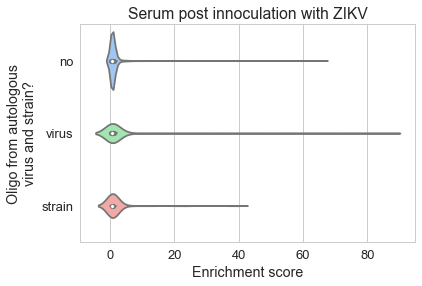

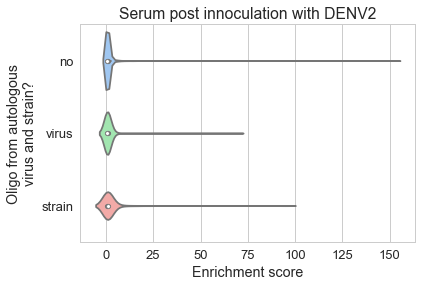

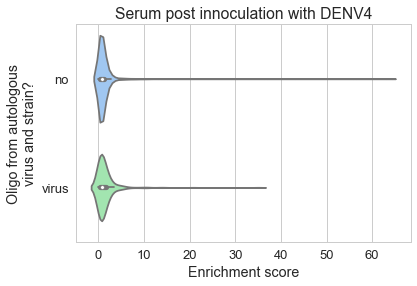

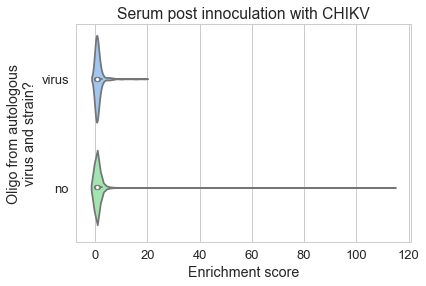

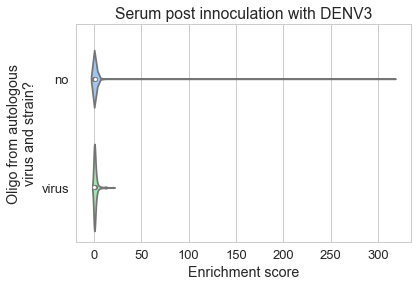

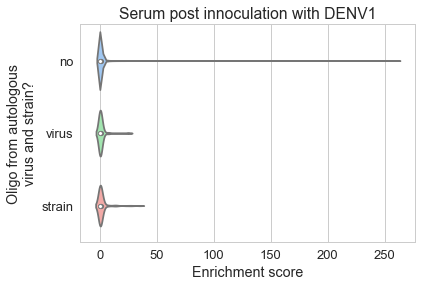

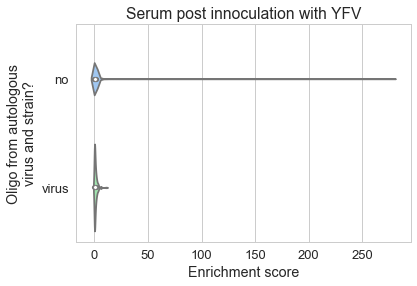

In [3]:
def get_autologous_serum(serum, df):
    ''' for a given serum sample, return a categorical series indicating whether 
    each oligo in the dataframe is from an autologous virus and/or strain'''
    autologous_strain = autologous_strains[serum].upper()
    autologous_virus = serum
    
    def is_autologous(row):
        if row['virus'] == autologous_virus and autologous_strain in row['strains']:
            return 'strain'
        elif row['virus'] == autologous_virus: # strain not autologous but virus is
            return 'virus'
        else: # totally different virus
            return 'no'
    
    autologous = df.apply(is_autologous, axis=1) # map to every row in the dataframe
    return autologous # return series (the index values here are the same in the original df, so they can be matched up later)

def plot_sera_distrib(serum, df):
    autologous = get_autologous_serum(serum, df) # categorize oligos by autologous-ness at virus and strain level
    ax = sns.violinplot(df[serum], autologous) # plot distribution of enrichment scores from each category
    ax.set_ylabel('Oligo from autologous\nvirus and strain?')
    ax.set_xlabel('Enrichment score')
    ax.set_title('Serum post innoculation with '+serum)
    plt.show()
    plt.close()
    
for serum in sample_cols:
    plot_sera_distrib(serum, data)

In [5]:
def max_over_mean(row):
    max_val = row[sample_cols].max()
    mean_val = row[sample_cols].mean()
    return max_val / mean_val

def max_heterologous(row):
    virus = row['virus']
    if virus not in sample_cols:
        return np.nan
    heterologous_cols = [c for c in sample_cols if c != virus]
    heterologous_val = row[heterologous_cols].max()
    return heterologous_val

def autologous(row):
    virus = row['virus']
    if virus not in sample_cols:
        return np.nan
    else:
        return row[virus]

data['max_over_mean'] = data.apply(max_over_mean, axis=1)
data['max_enrichment'] = data[sample_cols].max(axis=1)   
data['max_heterologous'] = data.apply(max_heterologous, axis=1)
data['autologous'] = data.apply(autologous, axis=1)

/Users/Sidney/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


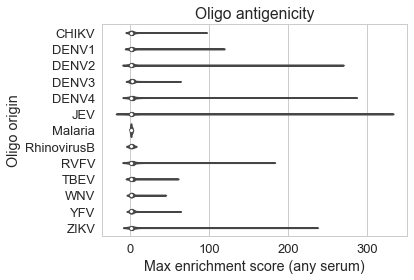

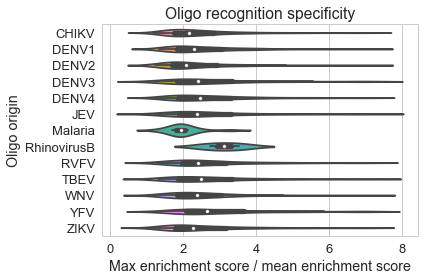

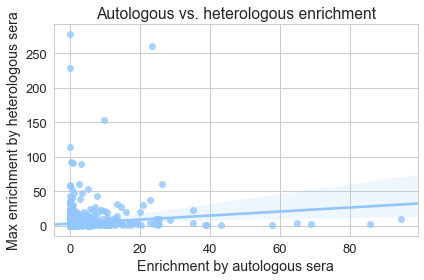

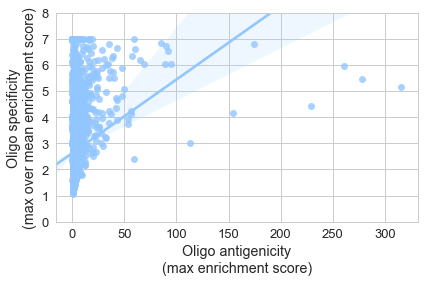

In [13]:
ax = sns.violinplot(x='max_enrichment', y='virus', data=data)
ax.set_title('Oligo antigenicity')
ax.set_xlabel('Max enrichment score (any serum)')
ax.set_ylabel('Oligo origin')
plt.tight_layout()
plt.show()
plt.close()

ax = sns.violinplot(x='max_over_mean', y='virus', data=data)
ax.set_title('Oligo recognition specificity')
ax.set_xlabel('Max enrichment score / mean enrichment score')
ax.set_ylabel('Oligo origin')
plt.tight_layout()
plt.show()
plt.close()

have_autologous = data.dropna(axis=0, subset=['autologous'])
ax = sns.regplot(x='autologous', y='max_heterologous', data=have_autologous)
ax.set_xlabel('Enrichment by autologous sera')
ax.set_ylabel('Max enrichment by heterologous sera')
ax.set_title('Autologous vs. heterologous enrichment')
plt.tight_layout()
plt.show()
plt.close()

ax = sns.regplot('max_enrichment', 'max_over_mean', data=data)
ax.set_xlabel('Oligo antigenicity\n(max enrichment score)')
ax.set_ylabel('Oligo specificity\n(max over mean enrichment score)')
ax.set_ylim(0,8)
plt.tight_layout()
plt.show()
plt.close()